In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

# Download NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Neelay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Neelay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load Datasets

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents = newsgroups_train.data
labels = newsgroups_train.target
label_names = newsgroups_train.target_names

### EDA

#### Dataset summary

In [3]:
print("Number of documents:", len(documents))
print("Number of categories:", len(label_names))
print("Categories:", label_names)

Number of documents: 11314
Number of categories: 20
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


#### Distribution of categories

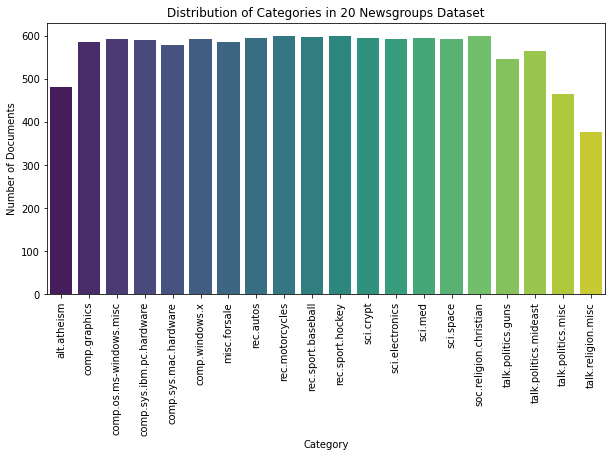

In [4]:
category_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.title('Distribution of Categories in 20 Newsgroups Dataset')
plt.xticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=90)
plt.show()

#### Document length analysis

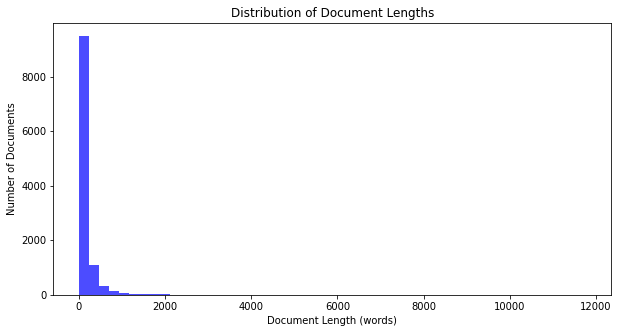

In [5]:
document_lengths = [len(doc.split()) for doc in documents]
plt.figure(figsize=(10, 5))
plt.hist(document_lengths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Document Length (words)')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths')
plt.show()

### Preprocessing Data

#### Removing Stop Words

In [6]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

documents = [preprocess(doc) for doc in documents]

#### Vectorization

In [7]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents)

### Model Building

#### LDA (Gensim)
##### Explanation: LDA (Latent Dirichlet Allocation) is a generative probabilistic model that assumes each document is a mixture of topics and each topic is a mixture of words.

In [8]:
corpus = Sparse2Corpus(X, documents_columns=False)
id2word = Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))
lda_model_gensim = LdaModel(corpus, num_topics=10, id2word=id2word, passes=10)

#### LDA (scikit-learn)
##### Explanation: Another implementation of LDA using scikit-learn which follows the same probabilistic approach.

In [9]:
lda_model_sklearn = LatentDirichletAllocation(n_components=10, random_state=0)
lda_topics_sklearn = lda_model_sklearn.fit_transform(X)

#### NMF (Non-negative Matrix Factorization)
##### Explanation: NMF is a linear algebra technique that factorizes the document-term matrix into non-negative matrices. It’s useful for parts-based representation.

In [10]:
nmf_model = NMF(n_components=10, random_state=0)
nmf_topics = nmf_model.fit_transform(X)

#### LSA (TruncatedSVD)
##### Explanation: LSA (Latent Semantic Analysis) uses SVD (Singular Value Decomposition) to reduce the dimensionality of the document-term matrix, capturing the underlying structure in the data.

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(documents)
lsa_model = TruncatedSVD(n_components=10, random_state=0)
lsa_topics = lsa_model.fit_transform(X_tfidf)

### Evaluation
##### Explanation: Coherence score measures the quality of the topics. Higher coherence scores indicate more interpretable topics.

In [12]:
coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=[doc.split() for doc in documents], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

### Visualisation

In [13]:
lda_vis = gensimvis.prepare(lda_model_gensim, corpus, id2word)
pyLDAvis.save_html(lda_vis, 'lda_gensim.html')

/Users/Neelay/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


##### Print top words for each topic for each model

In [14]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

##### Wordclouds for top words in each model

In [15]:
def plot_wordcloud(model, feature_names, title):
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(width=800, height=400, max_words=50, colormap='viridis').generate_from_frequencies(dict(zip(feature_names, model.components_.flatten())))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

##### Document distribution by topic for each model

In [16]:
def plot_topic_distribution(model, topics, title):
    topic_distribution = topics.argmax(axis=1)
    topic_counts = pd.Series(topic_distribution).value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
    plt.xlabel('Topic')
    plt.ylabel('Number of Documents')
    plt.title(title)
    plt.show()

In [17]:
n_top_words = 10

LDA Topics (scikit-learn):
Topic #0:
game team year games play season players hockey good new
Topic #1:
people government gun years states said new health control public
Topic #2:
max bhj giz wm ah gk bj ax bh air
Topic #3:
file use available program information files window data version image
Topic #4:
output file entry program dod rules new int printf line
Topic #5:
space president launch nasa years program april year satellite money
Topic #6:
drive thanks like card use know windows problem disk need
Topic #7:
key encryption government chip armenian security keys clipper israel privacy
Topic #8:
like car know said time people right good think way
Topic #9:
god people think know say like believe jesus time good



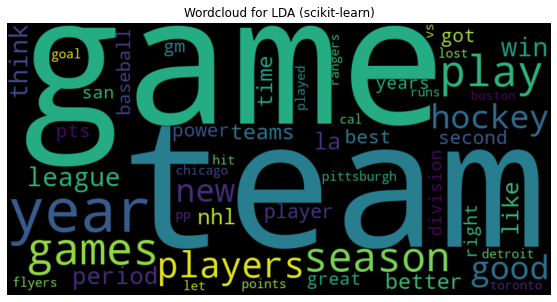

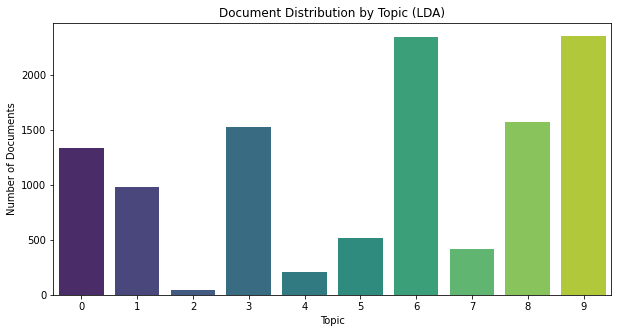

In [18]:
print("LDA Topics (scikit-learn):")
print_top_words(lda_model_sklearn, vectorizer.get_feature_names_out(), n_top_words)

plot_wordcloud(lda_model_sklearn, vectorizer.get_feature_names_out(), "Wordcloud for LDA (scikit-learn)")

plot_topic_distribution(lda_model_sklearn, lda_topics_sklearn, "Document Distribution by Topic (LDA)")

NMF Topics:
Topic #0:
max bhj giz gk bj wm qax kn ax nrhj
Topic #1:
db mov cs bh byte al si di bl bits
Topic #2:
image jpeg available version data use software images file widget
Topic #3:
people said know like say time went god think came
Topic #4:
output file entry oname program printf stream char buf fprintf
Topic #5:
file gun control states firearms united house handgun amendment crime
Topic #6:
anonymous internet privacy information email use mail anonymity computer posting
Topic #7:
stephanopoulos president think know going said package myers administration working
Topic #8:
hockey new league team nhl season games division draft game
Topic #9:
wire wiring use ground neutral subject circuit cable outlets nec



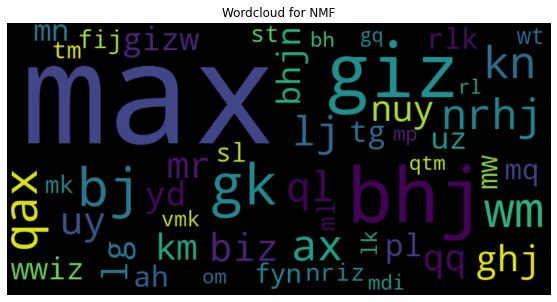

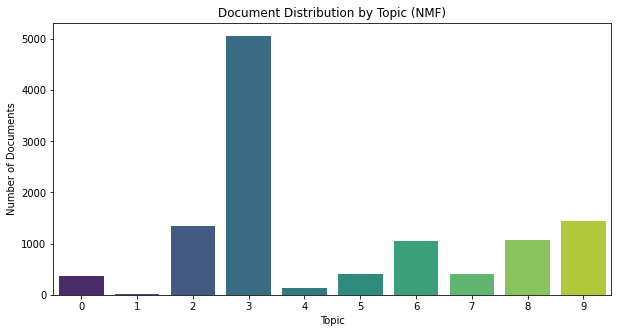

In [19]:
print("NMF Topics:")
print_top_words(nmf_model, vectorizer.get_feature_names_out(), n_top_words)

plot_wordcloud(nmf_model, vectorizer.get_feature_names_out(), "Wordcloud for NMF")

plot_topic_distribution(nmf_model, nmf_topics, "Document Distribution by Topic (NMF)")

LSA Topics:
Topic #0:
know like people think use good time thanks god new
Topic #1:
windows thanks card drive file dos use files software disk
Topic #2:
god jesus windows bible thanks faith card christ christian christians
Topic #3:
drive scsi drives hard card controller ide game disk year
Topic #4:
drive key chip encryption scsi clipper government keys drives disk
Topic #5:
geb chastity shameful intellect skepticism surrender gordon banks soon know
Topic #6:
thanks know advance email info looking hi information address send
Topic #7:
god key card chip game team games encryption clipper keys
Topic #8:
card video monitor people drivers cards vga driver car israel
Topic #9:
car new price sale bike window offer condition like shipping



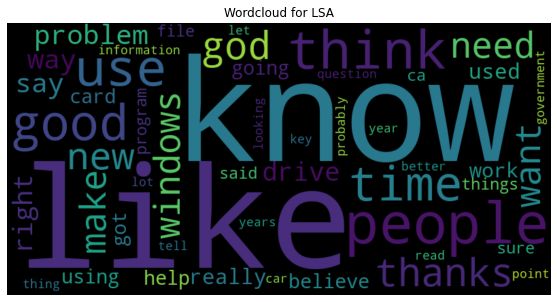

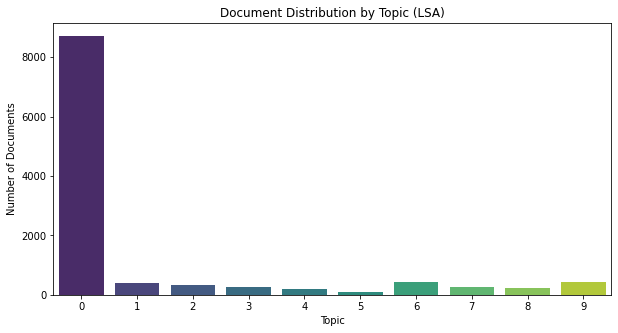

In [20]:
print("LSA Topics:")
print_top_words(lsa_model, tfidf_vectorizer.get_feature_names_out(), n_top_words)

plot_wordcloud(lsa_model, tfidf_vectorizer.get_feature_names_out(), "Wordcloud for LSA")

plot_topic_distribution(lsa_model, lsa_topics, "Document Distribution by Topic (LSA)")

#print(f"LDA Coherence Score (Gensim): {coherence_lda}")